In [ ]:
!nvidia-smi


In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'
MODEL_TYPE = "vit_h"


In [ ]:
print(DEVICE,torch.cuda.is_available())


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)


### Run this cell if running for first time

In [ ]:
# Run only if you dont have the below libraries
pip install git+https://github.com/facebookresearch/segment-anything.git
pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision


In [ ]:
# UNCOMMENT FOR FIRST TIME

# %cd {HOME}
# !mkdir {HOME+"\\weights"}
%cd {HOME+"\\weights"}

!wget -q "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))


In [ ]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
# sam.to(DEVICE, dtype=torch.half, non_blocking=True)


In [ ]:
# DO NOT RUN UNLESS YOU WANNA TEST MEMORY ISSUE

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF']='max_split_size_mb:1024' #'garbage_collection_threshold:0.8,max_split_size_mb:512'


In [266]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("arosphenotyping-nxtf4").project("blueberry_object_detection")
dataset = project.version(20).download("coco")


c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry
You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to blueberry_object_detection-20 in coco:: 100%|██████████| 299/299 [00:01<00:00, 285.38it/s]


In [ ]:
import time

time1 = time.time()

dataset = project.version(20) #Can be modified later
dataset_loc = os.path.join(HOME,dataset.name+"-"+dataset.version)
time2 = time.time()

print(time2-time1)



In [5]:
import pandas as pd
import math

def read_excluded():
    df = pd.read_csv("completed_list.csv", header=None, delimiter=',')
    # Create a dictionary of dictionaries
    result_dict = {'test': {}, 'train': {}, 'valid': {}}

    file_names = []
    flag = 0
    # Iterate through the DataFrame and populate the inner dictionaries
    for index, row in df.iterrows():
        if not isinstance(row[0], str):
            file_names = row[1:]
        else:
            type =  row[0].lower()
            for img_name, time in zip(file_names, row[1:]):
                print(img_name,time)
                if not math.isnan(float(time)):
                    result_dict[type][img_name] = float(time)
    del file_names
    return result_dict

times = read_excluded()
times = {'test': {}, 'train': {}, 'valid': {}}


H1-NC5286_-H2_2_3E_jpg.rf.0bb85d6b2bf556a137cec96c95664252.jpg 21.320784330368042
15-003_F2_18_21_jpg.rf.0378b9b5b771e54dec293d6af47330b5.jpg 5.909518003463745
NCV-06-1_F2_24_16_jpg.rf.00b4c1fd026755c5847cf5de76274ac3.jpg 5.252408504486084
H1-18-104_F2_36_2_jpg.rf.15c1c10b845208240bce02977c37de06.jpg 11.322800397872925
H1-NC5283_H2_6_5J_jpg.rf.2719bb1fdb1ad9aa6cf8dc3c57f1d24a.jpg 8.81895112991333
17-003_F2_23_13_jpg.rf.3eafcb7b88b69587a43a4a7577e1ee7a.jpg 6.971457242965698
H2-NC5282_H2_7_1F_jpg.rf.1bc2faae47a5e78c9a5e2eaa6c7f8160.jpg 6.59914755821228
NC5313_F2_15_17_jpg.rf.761bc20de596196d7bbbc5e938592ccf.jpg 8.238695859909058
H1-NC5271_H2_1_2I_jpg.rf.706e3024e675a51e6cde5211b07fee08.jpg 6.5349485874176025
Optimus_H2_5_4_jpg.rf.0290800eeb43c552a3c39181cd8da47b.jpg 5.411743879318237
NCV-03-2_F2_26_4_jpg.rf.0fe704757e681af1da142548159b6a54.jpg 6.554580450057983
18-015_F2_35_13_jpg.rf.3b6285b9ee0a547f8d0ff81ced2b74a1.jpg 5.620275020599365
H1-18-003_F2_31_12_jpg.rf.2b23f4f7aded3c9f8b00ee24

In [ ]:
import random
import cv2
import numpy as np
import sys

import supervision as sv


DATA_DIRECTORIES = [i for i in (os.listdir(dataset_loc)) if ".txt" not in i]
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

sam_predictor = SamPredictor(sam)

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

random.seed(2023)

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=False
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)




In [4]:
def image_count(subdirectory_path):
    # Specify the path to the subdirectory you want to count images in
    subdirectory_path = os.path.join(dataset_loc, subdirectory_path)

    # Initialize a count variable to keep track of the number of images
    image_count = 0

    # Iterate through the files in the subdirectory using os.scandir
    for entry in os.scandir(subdirectory_path):
        if entry.is_file() and entry.name.lower().endswith('.jpg'):
            image_count += 1
    return image_count


### Main Code

In [ ]:
import time
import os
import sys
import pandas as pd

# Define your constants and variables here, including dataset_loc, ANNOTATIONS_FILE_NAME, sv.DetectionDataset, sam_predictor, segment, etc.
# Make sure times is properly initialized with completed image data

DATA_DIRECTORIES = ['test', 'train', 'valid']
image_names = []
def mask_annotate():
    try:
        for DATA_SET_SUBDIRECTORY in DATA_DIRECTORIES:
            IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc, DATA_SET_SUBDIRECTORY)
            if len(times[DATA_SET_SUBDIRECTORY]) == image_count(IMAGES_DIRECTORY_PATH):
                continue

            # time_dir_start = time.time()
            print(DATA_SET_SUBDIRECTORY + " data Loading.......")

            ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, ANNOTATIONS_FILE_NAME)

            object_detection_dataset = sv.DetectionDataset.from_coco(
                images_directory_path=IMAGES_DIRECTORY_PATH,
                annotations_path=ANNOTATIONS_FILE_PATH
            )
            # del object_detection_dataset
            # detections = object_detection_dataset.annotations
            image_names = list(object_detection_dataset.images.keys())
            completed_images = set(times[DATA_SET_SUBDIRECTORY].keys())

            for image_name in image_names:
                if image_name.replace(IMAGES_DIRECTORY_PATH + "\\", "") not in completed_images:
                    time_img_start = time.time()
                    # Process the image and annotations here
                    # detection = detections[image_name]
                    object_detection_dataset.annotations[image_name].mask = segment(sam_predictor=sam_predictor, image=cv2.imread(image_name, cv2.COLOR_BGR2RGB),xyxy=object_detection_dataset.annotations[image_name].xyxy)
                    time_img_end = time.time()
                    # image_name = image_name.replace(IMAGES_DIRECTORY_PATH + "\\", "")
                    print(image_name + " processing time: " + str(time_img_end - time_img_start) + " secs")
                    print(sys.getsizeof(object_detection_dataset))
                    times[DATA_SET_SUBDIRECTORY][image_name.replace(IMAGES_DIRECTORY_PATH + "\\", "")] = time_img_end - time_img_start
            # time_dir_end = time.time()
            # print("Data dir " + DATA_SET_SUBDIRECTORY + " finished. Time taken = " + str(time_dir_end - time_dir_start) + " secs")
            object_detection_dataset.as_coco(annotations_path=ANNOTATIONS_FILE_PATH, images_directory_path=IMAGES_DIRECTORY_PATH)

            object_detection_dataset1 = sv.DetectionDataset.from_coco(
                images_directory_path=IMAGES_DIRECTORY_PATH,
                annotations_path=ANNOTATIONS_FILE_PATH
            )

            print("************************************************************")
            print(object_detection_dataset == object_detection_dataset1)
    except MemoryError:
        # Handle memory allocation issues here, if needed
        print("Memory allocation failed. Not enough memory available. Trying to free up memory")
        object_detection_dataset.as_coco(annotations_path=ANNOTATIONS_FILE_PATH, images_directory_path=None)
        # del object_detection_dataset
        del object_detection_dataset
        print("Saving completed files stats to CSV file")
        pd.DataFrame.from_dict(times, orient='index').to_csv('completed_list.csv')
        mask_annotate()

# Call the mask_annotate function to start the processing
mask_annotate()


### Testing

In [1]:
import random
import cv2
import numpy as np

import roboflow
from roboflow import Roboflow
import supervision as sv
import os
from segment_anything import sam_model_registry, SamPredictor
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'
MODEL_TYPE = "vit_h"

HOME = os.getcwd()

# Download SAM Weights into weights directory
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

sam_predictor = SamPredictor(sam)

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()


# Segmentation algorithm function, as given in Roboflow Notebook
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=False
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

# Roboflow loading downloaded dataset from local
roboflow.login()
rf = Roboflow()
project = rf.workspace("arosphenotyping-nxtf4").project("blueberry_object_detection") #Workspace_name , project_name
dataset = project.version(20) # Already downloaded the dataset


You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


In [6]:

# Paths definition
dataset_loc = os.path.join(HOME,dataset.name+"-"+dataset.version)
ANNOTATIONS_FILE_NAME = '_annotations.coco.json'
DATA_SET_SUBDIRECTORY = 'test'
IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, ANNOTATIONS_FILE_NAME)

# Loading the dataset using from_coco
object_detection_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_path=ANNOTATIONS_FILE_PATH
)
image_names = list(object_detection_dataset.images.keys())


In [13]:
# Getting a random image name
#
random.seed(random.choice([i for i in range(2024)]))
image_name = random.choice(image_names)
print(image_name.replace(IMAGES_DIRECTORY_PATH + "\\", ""))
# Applying segment function to update image annotation's mask attribute
object_detection_dataset.annotations[image_name].mask = segment(
sam_predictor=sam_predictor, image=cv2.imread(image_name, cv2.COLOR_BGR2RGB),xyxy=object_detection_dataset.annotations[image_name].xyxy)

# Saving annotation using as_coco (ISSUE HERE)
object_detection_dataset.as_coco(annotations_path=ANNOTATIONS_FILE_PATH, images_directory_path=IMAGES_DIRECTORY_PATH)


H1-NC5286_-H2_2_3E_jpg.rf.0bb85d6b2bf556a137cec96c95664252.jpg


In [16]:
import json
from pycocotools.coco import COCO

# Specify the path to your COCO annotation file
coco = COCO(ANNOTATIONS_FILE_PATH)





loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [17]:
# Check if the file exists and delete it if it does
if os.path.exists(ANNOTATIONS_FILE_PATH):
    os.remove(ANNOTATIONS_FILE_PATH)


In [18]:
with open(ANNOTATIONS_FILE_PATH, 'w') as outfile:
    json.dump(coco.dataset, outfile)


In [14]:
print(coco)


In [19]:
# Reading the dataset again to compare
object_detection_dataset1 = sv.DetectionDataset.from_coco(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_path=ANNOTATIONS_FILE_PATH
)

# # Output is FALSE!
print(object_detection_dataset.annotations == object_detection_dataset1.annotations)


False


In [6]:
object_detection_dataset1.as_coco(annotations_path=ANNOTATIONS_FILE_NAME, images_directory_path=IMAGES_DIRECTORY_PATH)


Entered save coco function!


In [5]:
# Reading the dataset again to compare
object_detection_dataset1 = sv_coco_read.DetectionDataset.from_coco(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_path=ANNOTATIONS_FILE_PATH
)
object_detection_dataset1.annotations[image_name].mask


In [20]:
print(object_detection_dataset1.annotations[image_name].mask)


None


In [26]:
print(object_detection_dataset.annotations[image_name].mask.shape)


(221, 3120, 4160)


In [9]:
"H1-NC5313_F2_15_17A_jpg.rf.2f02ad05c2a744c67fc8920da818c6b6.jpg"


'H1-NC5313_F2_15_17A_jpg.rf.2f02ad05c2a744c67fc8920da818c6b6.jpg'

### Modify Annotations once the images are cropped


In [35]:
print(image_name)


c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detection-20\test\H1-NC5286_-H2_2_3E_jpg.rf.0bb85d6b2bf556a137cec96c95664252.jpg


In [145]:
# ChatGPT wrote the code for image_bbox function:
# https://chat.openai.com/share/358f5b96-cb12-4f70-9ec5-07f359758c8f
# I changed the color threshold value.

def image_bbox(blueberry_filename):

    # Load the image
    image = cv2.imread(blueberry_filename)

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for the yellow color in HSV
    lower_yellow = np.array([20, 150, 150])
    upper_yellow = np.array([40, 255, 255])

    # Create a binary mask to isolate the yellow color
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Find the largest contour (assuming the yellow object is the largest)
        largest_contour = max(contours, key=cv2.contourArea)

        # Fit an oriented bounding box around the largest contour
        rect = cv2.minAreaRect(largest_contour)

        # Draw the oriented bounding box on the original image
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        return box

        # cv2.drawContours(image, [box], 0, (0, 0, 255), 5)  # red color for the bounding box

        # # Display the image with the bounding box

        # current_filename = './image1.png'
        # cv2.imwrite(current_filename, image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
    else:
        return None

# Crop the image based on the bounding box
# Calculate the bounding box coordinates
def image_crop_box(image_name):
    image = cv2.imread(image_name)
    box = image_bbox(image_name)
    if box.any():
        x, y, w, h = cv2.boundingRect(box)
    else:
        x, y, w, h = [0,0,image.shape[1],image.shape[0]]
    return [x,y,w,h]


In [ ]:
image_files =


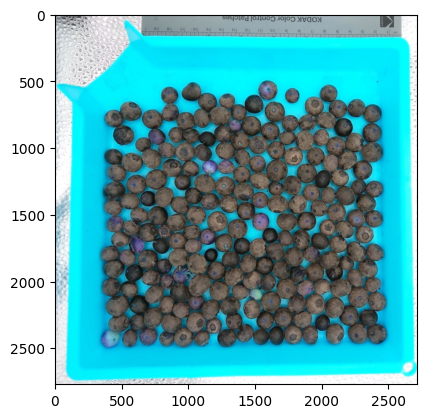

In [162]:
from matplotlib import pyplot as plt
image = cv2.imread(image_name)
x,y,w,h = image_crop_box(image_name)
cropped_image = image[y:y+h,x:x+w]
plt.imshow(cropped_image)


In [247]:
class ImageCropping:
    def __init__(self, image_path, annotations_path):
        self.annotations_path = annotations_path
        self.image_path = image_path
        self.image = cv2.cvtColor(cv2.imread(self.image_path),cv2.COLOR_BGR2RGB)
        self.x,self.y,self.w,self.h = self.image_crop_box()

    # ChatGPT wrote the code for image_bbox function:
    # https://chat.openai.com/share/358f5b96-cb12-4f70-9ec5-07f359758c8f
    # I changed the color threshold value.

    def image_bbox(self):
        # Load the image
        # Convert the image to the HSV color space
        hsv_image = cv2.cvtColor(self.image, cv2.COLOR_RGB2HSV)

        # Define the lower and upper bounds for the yellow color in HSV
        lower_yellow = np.array([20, 150, 150])
        upper_yellow = np.array([40, 255, 255])

        # Create a binary mask to isolate the yellow color
        yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            # Find the largest contour (assuming the yellow object is the largest)
            largest_contour = max(contours, key=cv2.contourArea)

            # Fit an oriented bounding box around the largest contour
            rect = cv2.minAreaRect(largest_contour)

            # Draw the oriented bounding box on the original image
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            return box

        else:
            return None

    # Crop the image based on the bounding box
    # Calculate the bounding box coordinates
    def image_crop_box(self):
        box = self.image_bbox()
        if box.any():
            x, y, w, h = cv2.boundingRect(box)
            if x < 0:
                x = 0
            if y < 0:
                y = 0
        else:
            x, y, w, h = [0,0,self.image.shape[1],self.image.shape[0]]
        return [x,y,w,h]

    def cropped_image(self):
        cropped_image = self.image[self.y:self.y+self.h,self.x:self.x+self.w]
        return cropped_image

    def get_image_id(self,coco_data):
        target_image_name = self.image_path.replace(IMAGES_DIRECTORY_PATH,"")[1:]
        # Initialize a variable to store the image_id
        image_id = None
        # Iterate through the images in the COCO dataset
        for image in coco_data['images']:
            if image['file_name'] == target_image_name:
                image_id = image['id']
                break  # Stop the loop once a matching image is found
        return image_id

    def modify_detection_bboxes(self,coco_data):
        # Find the annotation entry for the specified image ID
        detection_boxes = []
        for i in range(len(coco_data['annotations'])):
            if coco_data['annotations'][i]['image_id'] == self.get_image_id(coco_data):
                # Update the bounding box coordinates (assuming [x, y, width, height] format)
                # Replace with the new coordinates
                coco_data['annotations'][i]['bbox'][0] -= self.x
                coco_data['annotations'][i]['bbox'][1] -= self.y
                detection_boxes.append(coco_data['annotations'][i]['bbox'])
        return detection_boxes


In [267]:
import json

DATA_DIRECTORIES = ['test','train', 'valid']

for DATA_SET_SUBDIRECTORY in DATA_DIRECTORIES:
    IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc, DATA_SET_SUBDIRECTORY)
    ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, ANNOTATIONS_FILE_NAME)

    # Load the COCO annotations file
    with open(ANNOTATIONS_FILE_PATH, 'r') as f:
        coco_data = json.load(f)

    image_names = [os.path.join(IMAGES_DIRECTORY_PATH,f) for f in os.listdir(IMAGES_DIRECTORY_PATH) if f.lower().endswith('.jpg')]

    for image_name in image_names:
        print(DATA_SET_SUBDIRECTORY,image_name)
        image = ImageCropping(image_name,ANNOTATIONS_FILE_PATH)
        cropped_image = image.cropped_image()
        detection_boxes = image.modify_detection_bboxes(coco_data)
        # Saving the image
        cv2.imwrite(image_name, cv2.cvtColor(cropped_image,cv2.COLOR_BGR2RGB))

    with open(ANNOTATIONS_FILE_PATH, 'w') as outfile:
        json.dump(coco_data, outfile)



test c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detection-20\test\15-003_F2_18_21_jpg.rf.0378b9b5b771e54dec293d6af47330b5.jpg
test c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detection-20\test\16-049_F2_32_12_jpg.rf.9f4717644d0f5698b4dc405845af4105.jpg
test c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detection-20\test\17-002_F2_23_12_jpg.rf.a336f28ee12e1ce650053f2c6da07bda.jpg
test c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detection-20\test\17-003_F2_23_13_jpg.rf.3eafcb7b88b69587a43a4a7577e1ee7a.jpg
test c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detection-20\test\17-004_22_13_jpg.rf.f2bca86da1332ec3196e284d0e939b35.jpg
test c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detection-20\test\17-004_22_17_jpg.rf.7a3c53ceda53fd328ab54f5937cf5281.jpg
test c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detect

In [259]:
image_names = [os.path.join(os.path.join(dataset_loc, 'valid'),f) for f in os.listdir(os.path.join(os.path.join(dataset_loc, 'valid'))) if f.lower().endswith('.jpg')]


In [263]:
image_names


['c:\\Users\\sasan\\OneDrive\\Desktop\\CSC630\\aros-blueberry\\blueberry_object_detection-20\\valid\\18-066_F2_27_16_jpg.rf.9d17aca4659115856cc31cf239a51673.jpg',
 'c:\\Users\\sasan\\OneDrive\\Desktop\\CSC630\\aros-blueberry\\blueberry_object_detection-20\\valid\\18-075_F2_30_8_jpg.rf.74b5e6f5aa711d0576bb576b5dc1d51c.jpg',
 'c:\\Users\\sasan\\OneDrive\\Desktop\\CSC630\\aros-blueberry\\blueberry_object_detection-20\\valid\\H1-13-040_F2_23_8_jpg.rf.4cb3575db9c7ab77f95ec5337a2a38b5.jpg',
 'c:\\Users\\sasan\\OneDrive\\Desktop\\CSC630\\aros-blueberry\\blueberry_object_detection-20\\valid\\H1-17-005_F2_24_5_jpg.rf.214e1a143c389ad14c30e55bd9b84d83.jpg',
 'c:\\Users\\sasan\\OneDrive\\Desktop\\CSC630\\aros-blueberry\\blueberry_object_detection-20\\valid\\H1-17-006_F2_24_4_jpg.rf.3fed913e2b37b56909ef5896953adc4b.jpg',
 'c:\\Users\\sasan\\OneDrive\\Desktop\\CSC630\\aros-blueberry\\blueberry_object_detection-20\\valid\\H1-17-007_F2_23_10_jpg.rf.73db814b3627c22aa01faa503d75149d.jpg',
 'c:\\Users\\s

In [264]:
image = ImageCropping(image_names[10], ANNOTATIONS_FILE_NAME)


AttributeError: 'NoneType' object has no attribute 'any'

In [265]:
image_names[10]


'c:\\Users\\sasan\\OneDrive\\Desktop\\CSC630\\aros-blueberry\\blueberry_object_detection-20\\valid\\H1-18-061_F2_30_4_jpg.rf.936e95f23d06f4bc3280c96965e3c7d1.jpg'

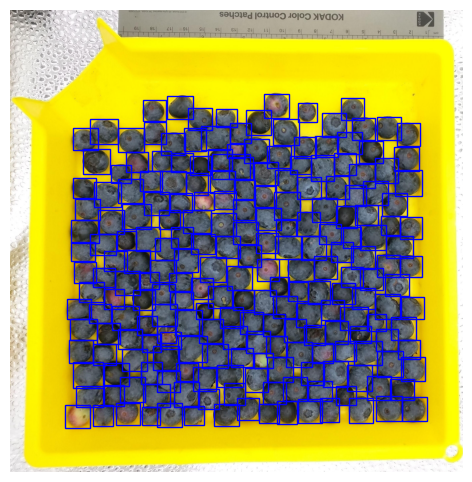

In [171]:
# TESTING IF THE CODE HAS ACTUALLY WORKED FOR A SAMPLE IMAGE

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib

# Iterate through the COCO annotations and draw them on the axis
for i in range(len(coco_data['annotations'])):
    if coco_data['annotations'][i]['image_id'] == image_id:
        ix, iy, iwidth, iheight = coco_data['annotations'][i]['bbox']
        label = coco_data['annotations'][i]['category_id']  # Assuming 'category_id' is used as a label

        # Draw a bounding box
        rect = patches.Rectangle((ix,iy), iwidth, iheight, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        # detection_boxes1.append([ix-x,iy-y,iwidth,iheight])
    # Display the label
    # ax.text(x, y - 5, str(label), color='g', fontsize=12, backgroundcolor='black')

# Hide axis labels and ticks
ax.axis('off')

# Show the Matplotlib plot
plt.show()


In [173]:
with open(ANNOTATIONS_FILE_PATH, 'w') as outfile:
    json.dump(coco_data, outfile)


In [178]:
# TESTING IF THE COCO JSON FILE IS PROPERLY SAVED
with open(ANNOTATIONS_FILE_PATH,'r') as read_file:
    coco_data1 = json.load(read_file)
coco_data1 == coco_data


True

In [177]:
# Saving the image
cv2.imwrite(image_name, cropped_image)


True

### First Demo for masks

In [ ]:
import random
import cv2
import numpy as np

import supervision as sv

DATA_DIRECTORIES = [i for i in (os.listdir(dataset_loc)) if ".txt" not in i]
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

sam_predictor = SamPredictor(sam)

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

random.seed(2023)

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=False
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

DATA_SET_SUBDIRECTORY = 'test'

IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, ANNOTATIONS_FILE_NAME)

object_detection_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_path=ANNOTATIONS_FILE_PATH
)

time_img_start = time.time()
image_names = list(object_detection_dataset.images.keys())
CLASSES = np.unique(object_detection_dataset.classes)

image_name = random.choice(image_names)
image_name.replace(dataset_loc+"\\train\\","")

image = object_detection_dataset.images[image_name]
detections = object_detection_dataset.annotations[image_name]
# box_annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, skip_label=True)
# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)
time_img_end = time.time()
image_name = image_name.replace(IMAGES_DIRECTORY_PATH+"\\","")
print(image_name+ " processing time: " + str(time_img_end - time_img_start) + " secs")


# annotate image with detections
labels = [f"{CLASSES[class_id-1]} {class_id}"
    for _, _, confidence, class_id, _
    in detections]
mask_annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)


In [ ]:
%matplotlib inline
sv.plot_image(mask_annotated_image,size = (6,6))


In [ ]:
sv.plot_image(image,size = (6,6))


### Testing annotations

In [ ]:
import pycocotools.coco

# Initialize the COCO API.
ANNOTATIONS_FILE_PATH1 = os.path.join(dataset_loc, DATA_SET_SUBDIRECTORY, "_annotations.coco.json")
coco = pycocotools.coco.COCO(ANNOTATIONS_FILE_PATH)


In [ ]:
# Find the annotation that has the same image name.
ann_id = coco.getAnnIds(imgIds=coco.getImgIds(image_name.replace(dataset_loc+"\\train\\","")))

# Print the annotation ID.
print(ann_id)


In [ ]:
# Iterate over the images list and get the file name and id for each image
image_filenames = []
for i in coco.loadImgs(coco.getImgIds()):
    image_filenames.append((i['id'],i['file_name']))

# Print the image file names and IDs
print(image_filenames)


In [ ]:
for i in coco.loadImgs(coco.getImgIds()):
    print(i)
    break


## Testing if Roboflow and SAM are working!

In [ ]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)


In [ ]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)


In [ ]:
print(sam_result[0])


In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(EXAMPLE_IMAGE_PATH)
widget


In [ ]:
widget.bboxes


In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])


In [ ]:
import cv2

image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)


In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.green())
mask_annotator = sv.MaskAnnotator(color=sv.Color.green())

detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=masks),mask=masks)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()


In [ ]:
project = rf.workspace("arosphenotyping-nxtf4").project("blueberry_object_detection")
dataset = project.version(20).download("coco")


In [ ]:
DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)


In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )


In [ ]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]


In [ ]:
CLASSES


In [ ]:
import random
random.seed(2023)


In [ ]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth, skip_label=True)

# run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.mean(detections.area)]
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image_rgb)
